# CT Image + Segmentation Images

CT Pixel Dimensions (mm): [0.9758117  0.97581184 4.987864  ]
CT Shape: [629 629 224]


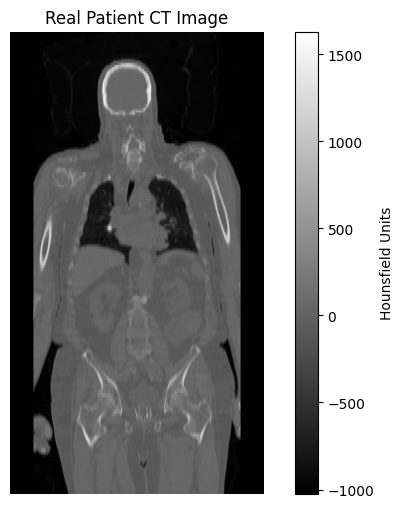

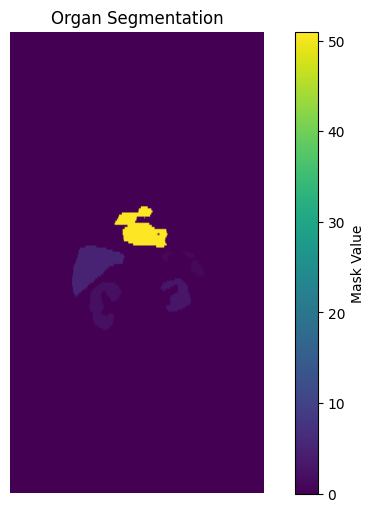

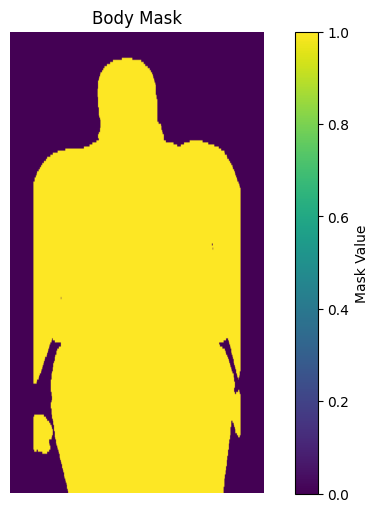

Shapes:
CT: (224, 629, 629)
Segmentation: (224, 629, 629)
Body mask: (224, 629, 629)


In [1]:
import matplotlib.pyplot as plt
import SimpleITK as sitk
import nibabel as nib

def plot_medical_images(ct_path, ml_seg_path, body_seg_path, slice_idx=None):
    """Plot CT, segmentation and body mask separately with proper orientation"""
    
    ct = nib.load(ct_path)
    ct_pixel_dim = ct.header['pixdim'][1:4]
    ct_shape = ct.header['dim'][1:4]
    print(f"CT Pixel Dimensions (mm): {ct_pixel_dim}")
    print(f"CT Shape: {ct_shape}")
    
    # Load images
    ct_img = sitk.GetArrayFromImage(sitk.ReadImage(ct_path))
    ml_seg = sitk.GetArrayFromImage(sitk.ReadImage(ml_seg_path))
    body_seg = sitk.GetArrayFromImage(sitk.ReadImage(body_seg_path))
    
    if slice_idx is None:
        slice_idx = ct_img.shape[1] // 2
        
    # Plot CT
    plt.figure(figsize=(8, 6))
    im1 = plt.imshow(ct_img[:, slice_idx, :][::-1], cmap='gray', aspect=ct_pixel_dim[2]/ct_pixel_dim[0])
    plt.title('Real Patient CT Image')
    plt.colorbar(im1, label='Hounsfield Units')
    plt.axis('off')
    plt.show()
    
    # Plot ML segmentation
    plt.figure(figsize=(8, 6))
    im2 = plt.imshow(ml_seg[:, slice_idx, :][::-1],aspect=ct_pixel_dim[2]/ct_pixel_dim[0])
    plt.title('Organ Segmentation')
    plt.colorbar(im2, label='Mask Value')
    plt.axis('off')
    plt.show()
    
    # Plot body segmentation
    plt.figure(figsize=(8, 6))
    im3 = plt.imshow(body_seg[:, slice_idx, :][::-1],aspect=ct_pixel_dim[2]/ct_pixel_dim[0])
    plt.title('Body Mask')
    plt.colorbar(im3, label='Mask Value')
    plt.axis('off')
    plt.show()
    
    print("Shapes:")
    print(f"CT: {ct_img.shape}")
    print(f"Segmentation: {ml_seg.shape}")
    print(f"Body mask: {body_seg.shape}")
    
    return ct_img, ml_seg, body_seg

# Example usage
ct_path = "/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/Output_Folder_Poster_For_real/TOTSEG_Outputs/TOTSEG_ct_input.nii.gz"
ml_seg_path = "/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/Output_Folder_Poster_For_real/TOTSEG_Outputs/TOTSEG_ml_segmentation.nii.gz"
body_seg_path = "/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/Output_Folder_Poster_For_real/TOTSEG_Outputs/TOTSEG_body_segmentation.nii.gz/body.nii.gz"

ct_vol, ml_seg_vol, body_seg_vol = plot_medical_images(ct_path, ml_seg_path, body_seg_path)

# PBPK - TACs

['Liver', 'Kidney']


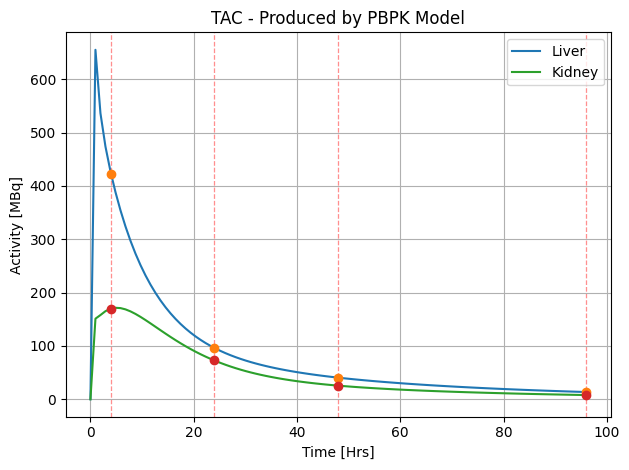

In [110]:
import os
import numpy as np
import matplotlib.pyplot as plt

def load_tac_bins(base_path, pbpk_name, voi):
    t  = np.fromfile(os.path.join(base_path, f"{pbpk_name}_{voi}_TAC_time.bin"),     dtype=np.float32)
    y  = np.fromfile(os.path.join(base_path, f"{pbpk_name}_{voi}_TAC_values.bin"),   dtype=np.float32)
    ts = np.fromfile(os.path.join(base_path, f"{pbpk_name}_{voi}_sample_times.bin"), dtype=np.float32)
    ys = np.fromfile(os.path.join(base_path, f"{pbpk_name}_{voi}_sample_values.bin"), dtype=np.float32)
    return t, y, ts, ys

def find_vois(base_path, pbpk_name):
    vois = []
    for fn in os.listdir(base_path):
        if fn.startswith(f"{pbpk_name}_") and fn.endswith("_TAC_time.bin"):
            voi = fn[len(pbpk_name)+1:-len("_TAC_time.bin")]
            vois.append(voi)
    vois.remove('Heart')
    vois.remove('Spleen')
    vois.remove('Rest')
    print(vois)
    return vois

def plot_tac_for_voi(base_path, pbpk_name, voi):
    t, y, ts, ys = load_tac_bins(base_path, pbpk_name, voi)

    plt.plot(t/60, y, label=voi, zorder=2)
    plt.plot(ts/60, ys, "o", zorder=3)

    # optional: faint verticals at frame times
    for x in ts:
        plt.axvline(x/60, color="red", linestyle="--", alpha=0.25, linewidth=0.9, zorder=1)

    #annotate each sampled value with a boxed label
    for x, v in zip(ts, ys):
        ax.annotate(
            f"t={int(round(x))} min ({x/60:.1f} hrs)\n{v:.3f} MBq",
            xy=(x, v),
            xytext=(6, 6), textcoords="offset points",
            ha="left", va="bottom",
            fontsize=10,
            bbox=dict(boxstyle="square,pad=0.2",
                      facecolor="white", edgecolor="black",
                      linewidth=1, alpha=0.9),
            zorder=4, clip_on=False
       )

    plt.xlabel("Time [Hrs]")
    plt.ylabel("Activity [MBq]")
    plt.title(f"TAC - Produced by PBPK Model")
    plt.legend()
    plt.grid()
    plt.tight_layout()


# -------------------- example usage --------------------
if __name__ == "__main__":
    base_path  = "/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/Output_Folder_Poster_For_real/PBPK_Outputs"
    pbpk_name  = "PBPK"

    for voi in find_vois(base_path, pbpk_name):
        required = [
            f"{pbpk_name}_{voi}_TAC_time.bin",
            f"{pbpk_name}_{voi}_TAC_values.bin",
            f"{pbpk_name}_{voi}_sample_times.bin",
            f"{pbpk_name}_{voi}_sample_values.bin",
        ]
        if not all(os.path.exists(os.path.join(base_path, r)) for r in required):
            continue
        plot_tac_for_voi(base_path, pbpk_name, voi)
        plt.grid(True)
plt.show()


# PBPK - Acitvity Map

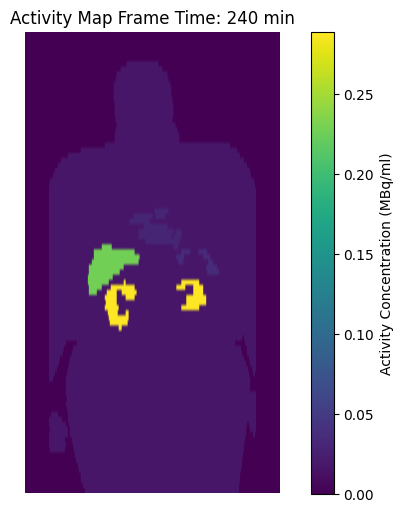

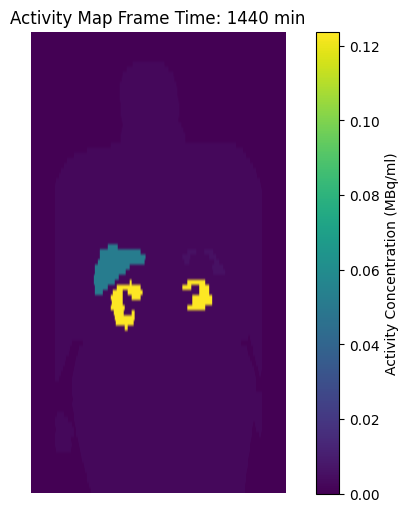

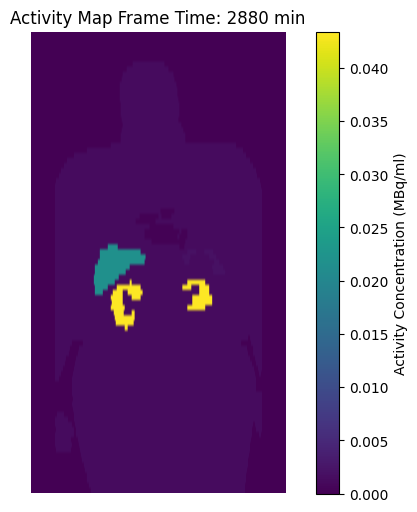

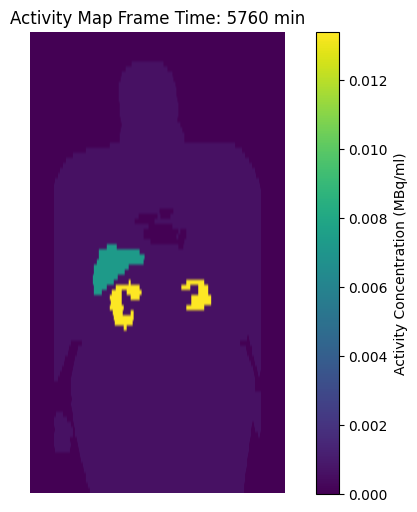

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def plot_activity_map(file_path, time_point):
    """Plot PBPK activity map for a given timepoint"""
    arr = np.fromfile(file_path, dtype=np.float32).reshape(91, 256, 256)
    
    plt.figure(figsize=(8, 6))
    im = plt.imshow(arr[::-1,128,:],aspect = 4.987864/0.9758117)
    plt.title(f'Activity Map Frame Time: {time_point} min')
    plt.colorbar(im, label='Activity Concentration (MBq/ml)')
    plt.axis('off')
    plt.show()
    return arr

# File paths
base_path = "/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/Output_Folder_Poster_For_real/PBPK_Outputs"
times = [240, 1440, 2880, 5760]
files = {t: f"{base_path}/PBPK_{t}_act_av.bin" for t in times}

# Plot each timepoint
activities = {}
for time, path in files.items():
    activities[time] = plot_activity_map(path, time)


# SIMIND - Projections

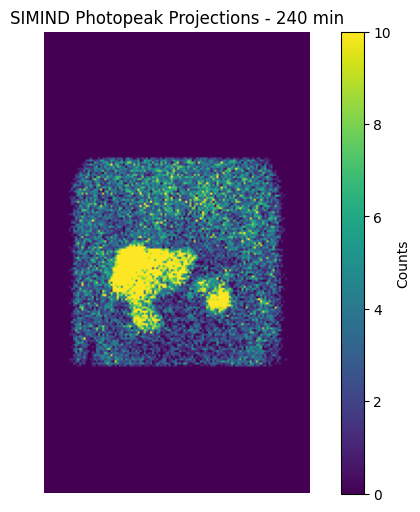

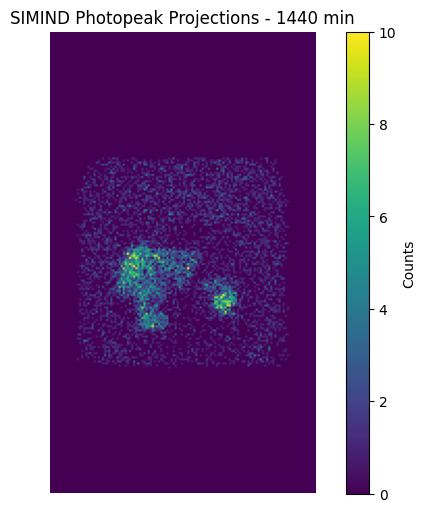

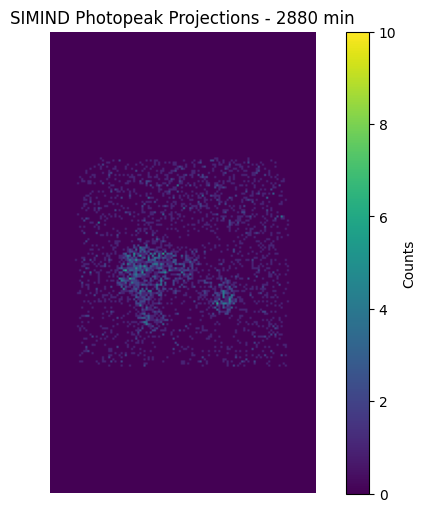

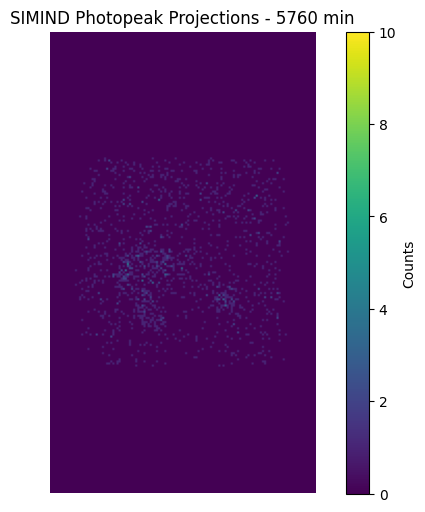

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_simind_projection(file_path, time_point):
    photopeak = np.fromfile(file_path, dtype=np.float32)
    projections = torch.poisson(torch.tensor(photopeak.reshape((64, 223, 128))))
    
    # Plot projection
    plt.figure(figsize=(8, 6))
    im = plt.imshow(projections[1,:,:])
    plt.colorbar(im, label='Counts')
    plt.title(f'SIMIND Photopeak Projections - {time_point} min')
    #print(f"Max value at {time_point} min: {np.max(projections):.2e}")
    plt.axis('off')
    plt.show()
    return projections

# File paths for each timepoint
base_path = "Output_Folder_Poster_For_real/SIMIND_Outputs"
paths = {
    240: f"{base_path}/simind_240min_tot_w2.a00",
    1440: f"{base_path}/simind_1440min_tot_w2.a00",
    2880: f"{base_path}/simind_2880min_tot_w2.a00",
    5760: f"{base_path}/simind_5760min_tot_w2.a00"
}

# Plot each timepoint
projections = {}
for time, path in paths.items():
    projections[time] = plot_simind_projection(path, time)

# RECON - SPECT IMAGE

Shape at 240 min: (223, 128, 128)
6839.6865


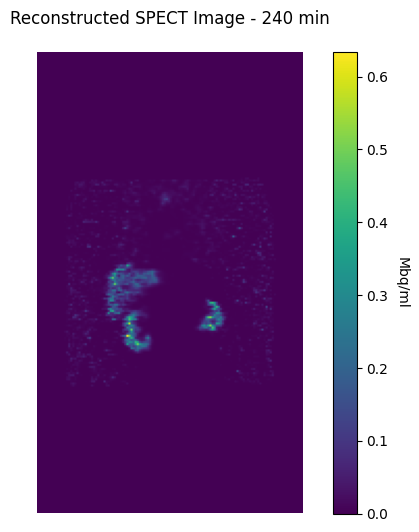

Max counts at 240 min: 7.78e-01

Shape at 1440 min: (223, 128, 128)
1791.7054


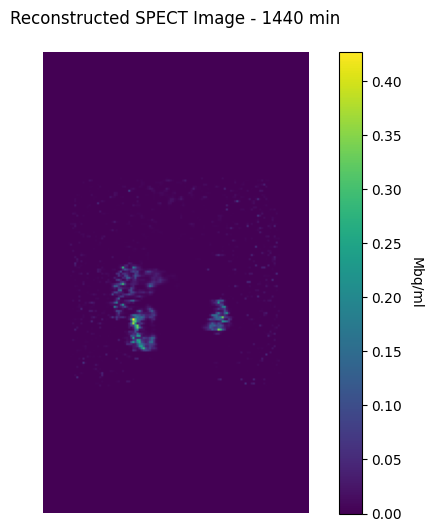

Max counts at 1440 min: 6.37e-01

Shape at 2880 min: (223, 128, 128)
756.49884


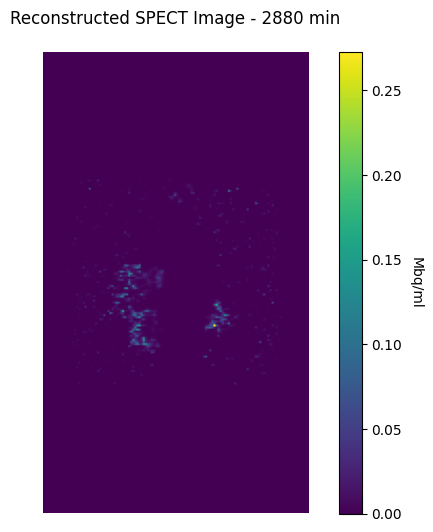

Max counts at 2880 min: 4.19e-01

Shape at 5760 min: (223, 128, 128)
302.4482


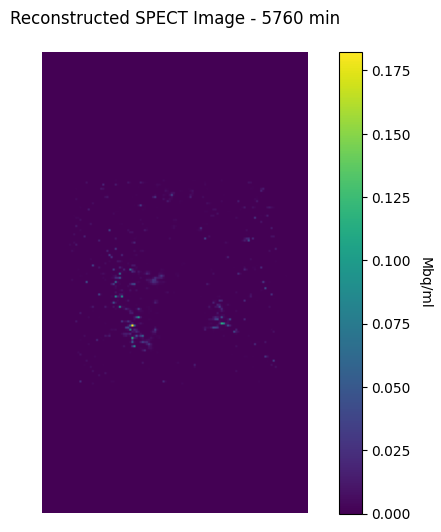

Max counts at 5760 min: 2.62e-01



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

def plot_recon_volume(file_path, time_point):
    """Plot a single reconstructed volume with improved formatting"""
    vol = sitk.GetArrayFromImage(sitk.ReadImage(file_path))
    print(f"Shape at {time_point} min:", vol.shape)
    print(np.sum(vol))
    
    plt.figure(figsize=(8, 6))
    im = plt.imshow(vol[:, 60, :][::-1], cmap='viridis')
    plt.title(f'Reconstructed SPECT Image - {time_point} min', pad=20)
    cbar = plt.colorbar(im)
    cbar.set_label('Mbq/ml', rotation=270, labelpad=15)
    plt.axis('off')
    plt.show()
    print(f"Max counts at {time_point} min: {np.max(vol):.2e}\n")
    return vol

# Base path
base_path = "/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/Output_Folder_Poster_For_real/RECON_Outputs"

# Time points and corresponding files
times = [240, 1440, 2880, 5760]
volumes = {}

# Plot each timepoint
for i, time in enumerate(times):
    file_path = f"{base_path}/RECON_frame{i}.nii"
    volumes[time] = plot_recon_volume(file_path, time)

    

# End of Test ( below is random code)

In [74]:
import numpy as np
import matplotlib.pyplot as plt

file_path1 = '/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/Output_Folder_Optimize/SIMIND_Outputs/simind_kidney_111_tot_w2.a00'


photopeak = np.fromfile(file_path1, dtype=np.float32)
projections1 = photopeak.reshape((64, 223, 128))

# Plot projection
plt.figure(figsize=(8, 6))
im = plt.imshow(projections1[0,:,:][:,::-1])
plt.colorbar(im, label='Counts/Emitted Photon')
plt.axis('off')
plt.show()

file_path2 = '/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/Output_Folder_Poster_ROI:[kidney, liver, spleen, heart]/SIMIND_Outputs/simind_kidney_tot_w2.a00'


photopeak = np.fromfile(file_path2, dtype=np.float32)
projections2 = photopeak.reshape((64, 223, 128))

# Plot projection
plt.figure(figsize=(8, 6))
im = plt.imshow(projections2[0,:,:][:,::-1])
plt.colorbar(im, label='Counts/Emitted Photon')
plt.axis('off')
plt.show()




projections3 = projections1-projections2

# Plot projection
plt.figure(figsize=(8, 6))
im = plt.imshow(projections3[0,:,:][:,::-1])
plt.colorbar(im, label='Counts/Emitted Photon')
plt.axis('off')
plt.show()



ValueError: cannot reshape array of size 1409024 into shape (64,223,128)

In [ ]:
import matplotlib.pyplot as plt
import SimpleITK as sitk
import nibabel as nib

def plot_medical_images(ct_path, ml_seg_path, body_seg_path, slice_idx=None):
    """Plot CT, segmentation and body mask separately with proper orientation"""
    
    ct = nib.load(ct_path)
    ct_pixel_dim = ct.header['pixdim'][1:4]
    ct_shape = ct.header['dim'][1:4]
    print(f"CT Pixel Dimensions (mm): {ct_pixel_dim}")
    print(f"CT Shape: {ct_shape}")
    
    # Load images
    ct_img = sitk.GetArrayFromImage(sitk.ReadImage(ct_path))
    ml_seg = sitk.GetArrayFromImage(sitk.ReadImage(ml_seg_path))
    body_seg = sitk.GetArrayFromImage(sitk.ReadImage(body_seg_path))
    
    if slice_idx is None:
        slice_idx = ct_img.shape[1] // 2
        
    # Plot CT
    plt.figure(figsize=(8, 6))
    im1 = plt.imshow(ct_img[:, slice_idx, :][::-1], cmap='gray', aspect=ct_pixel_dim[2]/ct_pixel_dim[0])
    plt.title('Real Patient CT Image')
    plt.colorbar(im1, label='Hounsfield Units')
    plt.axis('off')
    plt.show()
    
    # Plot ML segmentation
    plt.figure(figsize=(8, 6))
    im2 = plt.imshow(ml_seg[:, slice_idx, :][::-1],aspect=ct_pixel_dim[2]/ct_pixel_dim[0])
    plt.title('Organ Segmentation')
    plt.colorbar(im2, label='Mask Value')
    plt.axis('off')
    plt.show()
    
    # Plot body segmentation
    plt.figure(figsize=(8, 6))
    im3 = plt.imshow(body_seg[:, slice_idx, :][::-1],aspect=ct_pixel_dim[2]/ct_pixel_dim[0])
    plt.title('Body Mask')
    plt.colorbar(im3, label='Mask Value')
    plt.axis('off')
    plt.show()
    
    print("Shapes:")
    print(f"CT: {ct_img.shape}")
    print(f"Segmentation: {ml_seg.shape}")
    print(f"Body mask: {body_seg.shape}")
    
    return ct_img, ml_seg, body_seg

# Example usage
ct_path = "/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/Output_Folder_CTvsSPECT_Comparison/TOTSEG_Outputs/TOTSEG_ct_input.nii.gz"
ml_seg_path = "/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/Output_Folder_CTvsSPECT_Comparison/TOTSEG_Outputs/TOTSEG_ml_segmentation.nii.gz"
body_seg_path = "/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/Output_Folder_CTvsSPECT_Comparison/TOTSEG_Outputs/TOTSEG_body_segmentation.nii.gz/body.nii.gz"

ct_vol, ml_seg_vol, body_seg_vol = plot_medical_images(ct_path, ml_seg_path, body_seg_path)

CT Pixel Dimensions (mm): [0.9758117  0.97581184 4.987864  ]
CT Shape: [629 629 224]


RuntimeError: Exception thrown in SimpleITK ImageFileReader_Execute: /tmp/SimpleITK/Code/IO/src/sitkImageReaderBase.cxx:99:
sitk::ERROR: Unable to determine ImageIO reader for "/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/Output_Folder_Poster_ROI:[kidney, liver, spleen, heart]/TOTSEG_Outputs/TOTSEG_body_plus_ml_segmentation.bin"

In [ ]:
import pycno
VOIs_possible = ['Tumor1', 'Tumor2', 'Kidney', 'Heart', 'SG', 'Bone', 'TumorRest', 'Spleen', 'Liver', 'Prostate', 'GI', 'Rest', 'Skin', 'Brain', 'RedMarrow', 'Lungs', 'Adipose']
time, TACs = pycno.run_model(
        model_name="PSMA",
        stop=500,
        observables=VOIs_possible)

for i,v in enumerate(VOIs_possible):
        print(v)
        plt.plot(time,TACs[0,:,i],label = v)
        plt.legend()
plt.show()

# ORIENTATION CHECKING

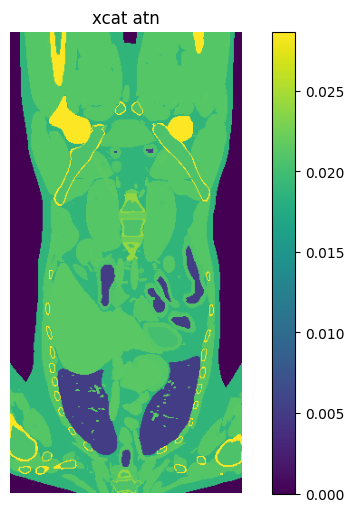

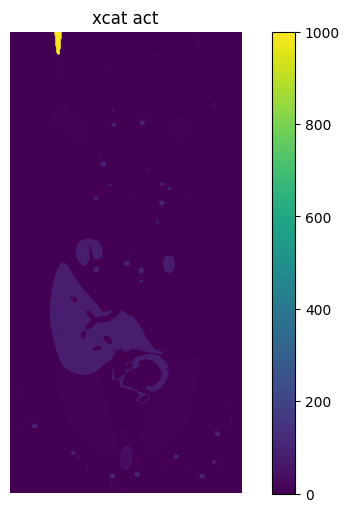

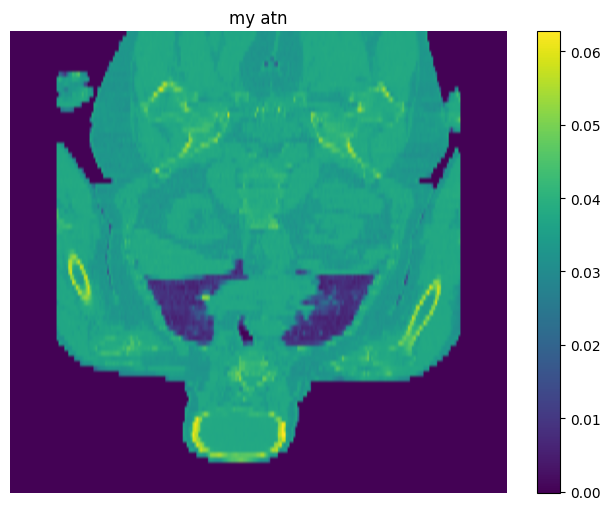

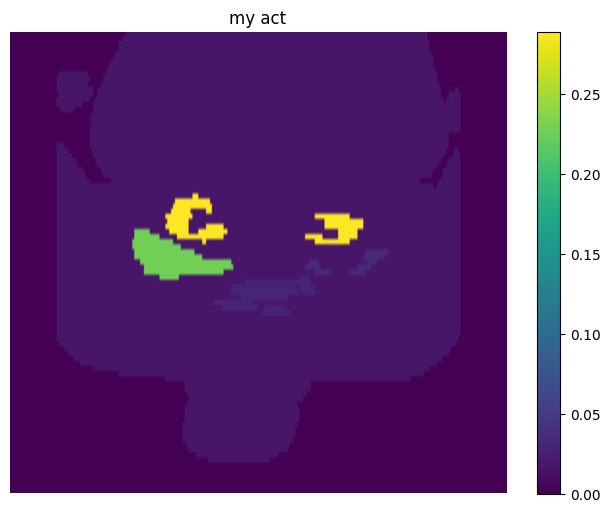

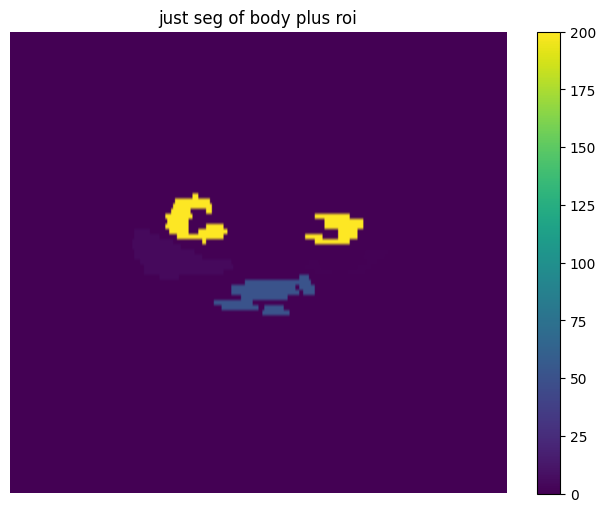

In [112]:
xcat_atn_path = '/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/test1_atn_1 2.bin'
xcat_act_path = '/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/test1_act_1 1.bin'

my_atn_path = '/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/Output_Folder_Poster_ROI:[kidney, liver, spleen, heart]/SIMIND_Outputs/TOTSEG_atn_av.bin'
my_act_path = '/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/Output_Folder_Poster_ROI:[kidney, liver, spleen, heart]/PBPK_Outputs/PBPK_240_act_av.bin'

arr_xcat_atn = np.fromfile(xcat_atn_path, dtype=np.float32).reshape(512, 256, 256)   
plt.figure(figsize=(8, 6))
im = plt.imshow(arr_xcat_atn[:,128,:])
plt.title("xcat atn")
plt.axis('off')
plt.colorbar()
plt.show()

arr_xcat_act = np.fromfile(xcat_act_path, dtype=np.float32).reshape(512, 256, 256)   
plt.figure(figsize=(8, 6))
im = plt.imshow(arr_xcat_act[:,128,:])
plt.title("xcat act")
plt.axis('off')
plt.colorbar()
plt.show()

arr_my_atn = np.fromfile(my_atn_path, dtype=np.float32).reshape(91, 256, 256)   
plt.figure(figsize=(8, 6))
im = plt.imshow(arr_my_atn[:,128,:],aspect='auto')
plt.title("my atn")
plt.axis('off')
plt.colorbar()
plt.show()


arr_my_act = np.fromfile(my_act_path, dtype=np.float32).reshape(91, 256, 256)   
plt.figure(figsize=(8, 6))
im = plt.imshow(arr_my_act[:,128,:],aspect='auto')
plt.title("my act")
plt.axis('off')
plt.colorbar()
plt.show()


just_seg_path = '/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/Output_Folder_Poster_ROI:[kidney, liver, spleen, heart]/TOTSEG_Outputs/TOTSEG_ml_segmentation.bin'
arr_just_seg = np.fromfile(just_seg_path, dtype=np.float32).reshape(91, 256, 256)   
plt.figure(figsize=(8, 6))
im = plt.imshow(arr_just_seg[:,128,:],aspect='auto')
plt.title("just seg of body plus roi")
plt.axis('off')
plt.colorbar()
plt.show()



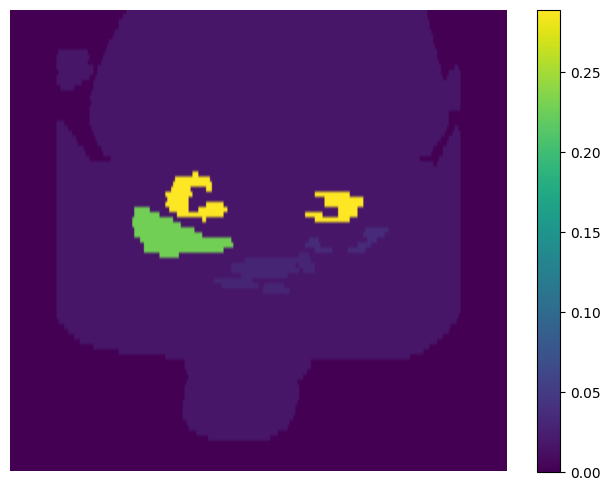

(91, 256, 256)
(55, 154, 154)
(91, 256, 256)
[0.         0.0172743  0.02992876 0.03451472 0.22750798 0.28919587]


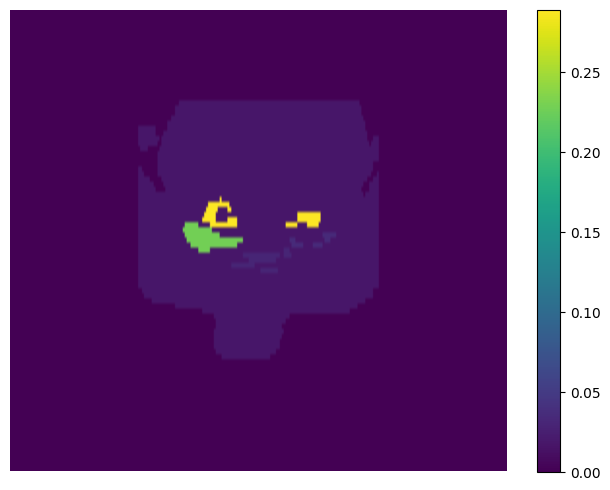

In [69]:
import numpy as np
from scipy import ndimage

path = '/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/Output_Folder_Poster_ROI:[kidney, liver, spleen, heart]/PBPK_Outputs/PBPK_240_act_av.bin'

arr = np.fromfile(path, dtype=np.float32).reshape(91, 256, 256)  
plt.figure(figsize=(8, 6))
im = plt.imshow(arr[:,arr.shape[1]//2,:],aspect='auto')
plt.axis('off')
plt.colorbar()
plt.show()
print(arr.shape) 
i = 0.6
x=int((arr.shape[0]-arr.shape[0]*i)/2)
y=int((arr.shape[1]-arr.shape[1]*i)/2)
z=int((arr.shape[2]-arr.shape[2]*i)/2)
arr = ndimage.zoom(arr,(i,i,i),order=0)
print(arr.shape)

arr = np.pad(arr,pad_width=((x,x),(y,y),(z,z)))
print(arr.shape)
print(np.unique(arr))
plt.figure(figsize=(8, 6))
im = plt.imshow(arr[:,arr.shape[1]//2,:],aspect='auto')
plt.axis('off')
plt.colorbar()
plt.show()

CT Pixel Dimensions (mm): [0.9758117  0.97581184 4.987864  ]
CT Shape: [629 629 224]


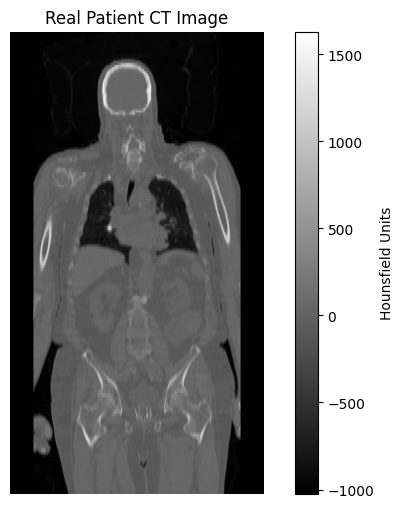

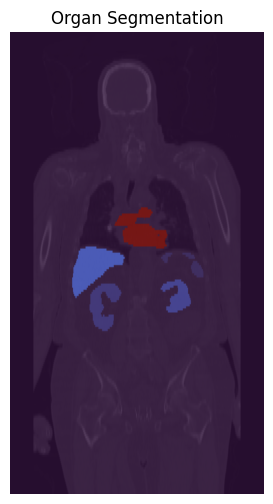

In [42]:
import matplotlib.pyplot as plt
import SimpleITK as sitk
import nibabel as nib


# Example usage
ct_path = "/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/Output_Folder_Poster_For_real/TOTSEG_Outputs/TOTSEG_ct_input.nii.gz"
ml_seg_path = "/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/Output_Folder_Poster_For_real/TOTSEG_Outputs/TOTSEG_ml_segmentation.nii.gz"
body_seg_path = "/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/Output_Folder_Poster_For_real/TOTSEG_Outputs/TOTSEG_body_segmentation.nii.gz/body.nii.gz"



ct = nib.load(ct_path)
ct_pixel_dim = ct.header['pixdim'][1:4]
ct_shape = ct.header['dim'][1:4]
print(f"CT Pixel Dimensions (mm): {ct_pixel_dim}")
print(f"CT Shape: {ct_shape}")

# Load images
ct_img = sitk.GetArrayFromImage(sitk.ReadImage(ct_path))
ml_seg = sitk.GetArrayFromImage(sitk.ReadImage(ml_seg_path))


slice_idx = ct_img.shape[1] // 2
    
# Plot CT
plt.figure(figsize=(8, 6))
im1 = plt.imshow(ct_img[:, slice_idx, :][::-1], cmap='gray', aspect=ct_pixel_dim[2]/ct_pixel_dim[0])
plt.title('Real Patient CT Image')
plt.colorbar(im1, label='Hounsfield Units')
plt.axis('off')
plt.show()

# Plot ML segmentation
plt.figure(figsize=(8, 6))

plt.imshow(ct_img[:, slice_idx, :][::-1], cmap='gray', aspect=ct_pixel_dim[2]/ct_pixel_dim[0])
plt.imshow(ml_seg[:, slice_idx, :][::-1],cmap='turbo',aspect=ct_pixel_dim[2]/ct_pixel_dim[0],alpha = 0.8)

plt.title('Organ Segmentation')
plt.axis('off')
plt.show()




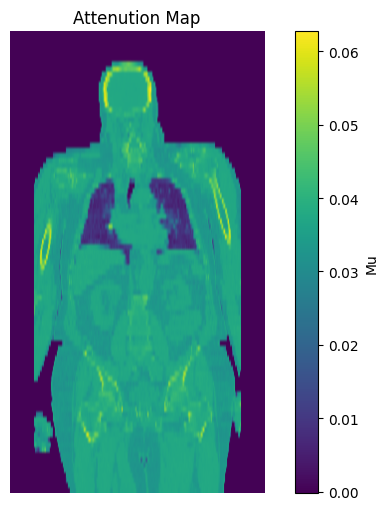

In [23]:
my_atn_path = '/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/Output_Folder_Poster_For_real/SIMIND_Outputs/TOTSEG_atn_av.bin'

arr_my_atn = np.fromfile(my_atn_path, dtype=np.float32).reshape(91, 256, 256)   
plt.figure(figsize=(8, 6))
im = plt.imshow(arr_my_atn[::-1,128,:],aspect=ct_pixel_dim[2]/ct_pixel_dim[0])
plt.title("Attenution Map")
plt.axis('off')
plt.colorbar(label = 'Mu')
plt.show()

29323.146


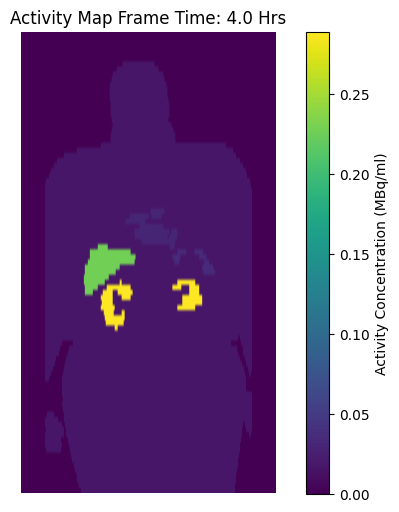

5881.1934


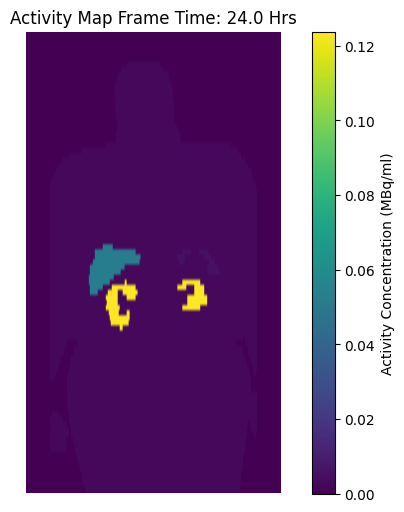

2382.6526


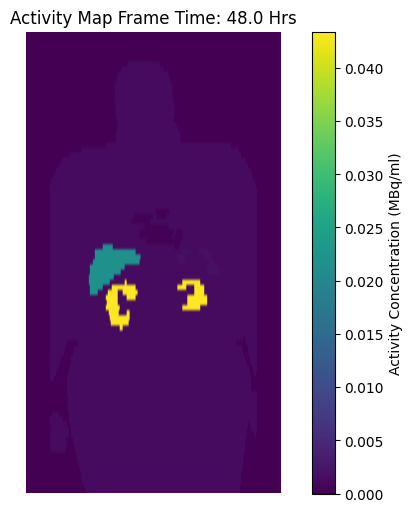

1009.03625


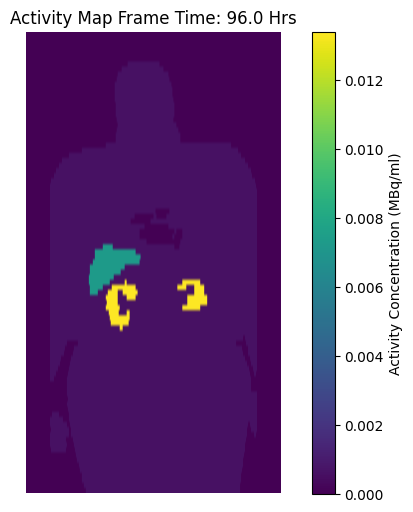

In [43]:
import numpy as np
import matplotlib.pyplot as plt

def plot_activity_map(file_path, time_point):
    """Plot PBPK activity map for a given timepoint"""
    arr = np.fromfile(file_path, dtype=np.float32).reshape(91, 256, 256)
    
    plt.figure(figsize=(8, 6))
    im = plt.imshow(arr[::-1,128,:],aspect=ct_pixel_dim[2]/ct_pixel_dim[0])
    plt.title(f'Activity Map Frame Time: {time_point/60} Hrs')
    plt.colorbar(im, label='Activity Concentration (MBq/ml)')
    plt.axis('off')
    plt.show()
    return arr

# File paths
base_path = "/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/Output_Folder_Poster_For_real/PBPK_Outputs"
times = [240, 1440, 2880, 5760]
files = {t: f"{base_path}/PBPK_{t}_act_av.bin" for t in times}

# Plot each timepoint
activities = {}
for time, path in files.items():
    activities[time] = plot_activity_map(path, time)


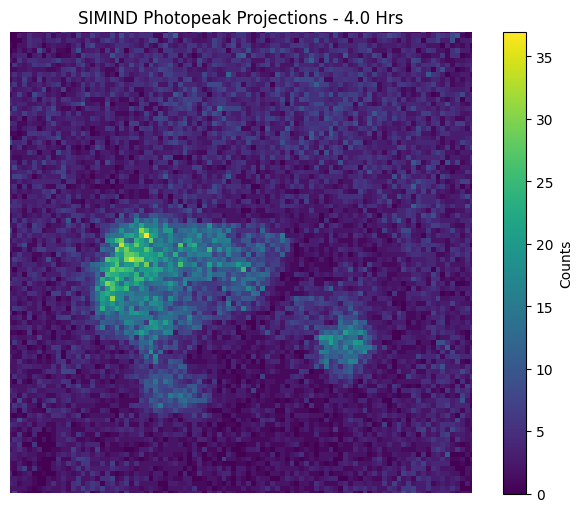

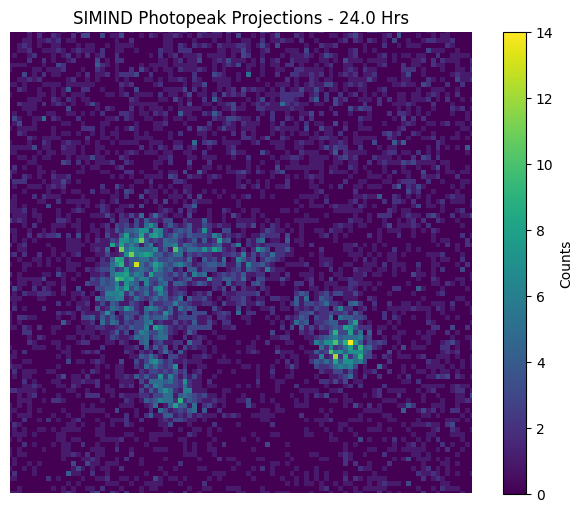

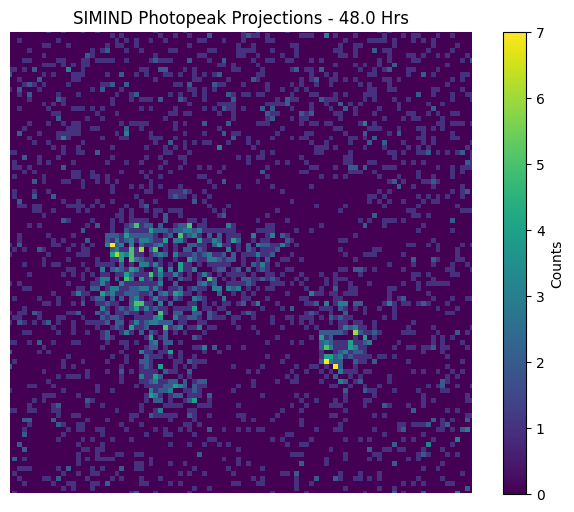

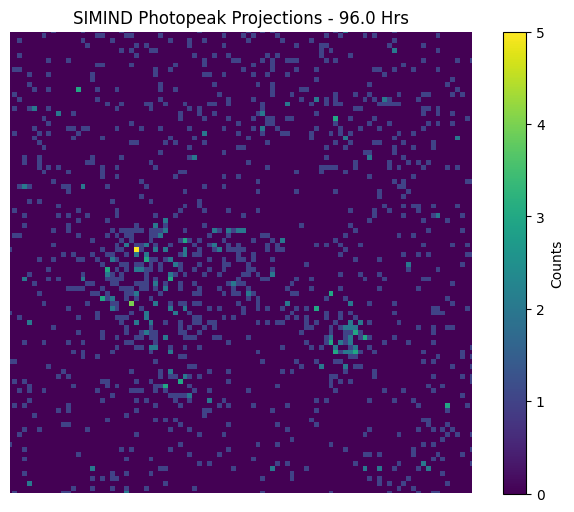

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_simind_projection(file_path, time_point):
    photopeak = np.fromfile(file_path, dtype=np.float32)
    projections = torch.poisson(torch.tensor(photopeak.reshape((64, 223, 128))))
    
    # Plot projection
    plt.figure(figsize=(8, 6))
    im = plt.imshow(projections[1,:,:])
    plt.ylim(65,160)
    plt.xlim(15,110)
    plt.colorbar(im, label='Counts')
    plt.title(f'SIMIND Photopeak Projections - {time_point/60} Hrs')
    #print(f"Max value at {time_point} min: {np.max(projections):.2e}")
    plt.axis('off')
    #plt.gca().invert_xaxis()                                       # vertical flip
    plt.gca().invert_yaxis()                                       # vertical flip
    plt.show()
    return projections

# File paths for each timepoint
base_path = "Output_Folder_Poster_For_real/SIMIND_Outputs"
paths = {
    240: f"{base_path}/simind_240min_tot_w2.a00",
    1440: f"{base_path}/simind_1440min_tot_w2.a00",
    2880: f"{base_path}/simind_2880min_tot_w2.a00",
    5760: f"{base_path}/simind_5760min_tot_w2.a00"
}

# Plot each timepoint
projections = {}
for time, path in paths.items():
    projections[time] = plot_simind_projection(path, time)

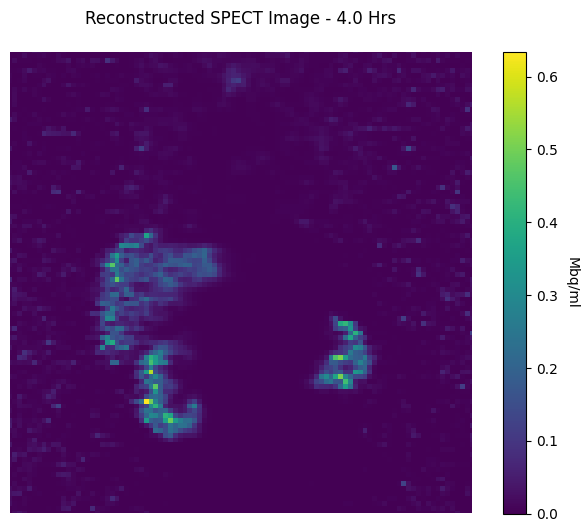

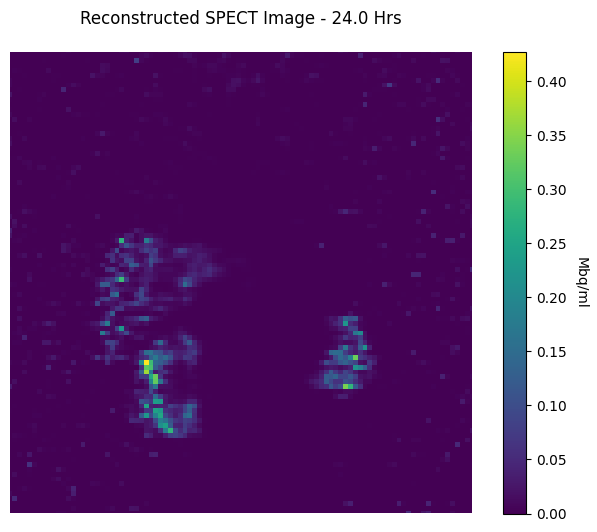

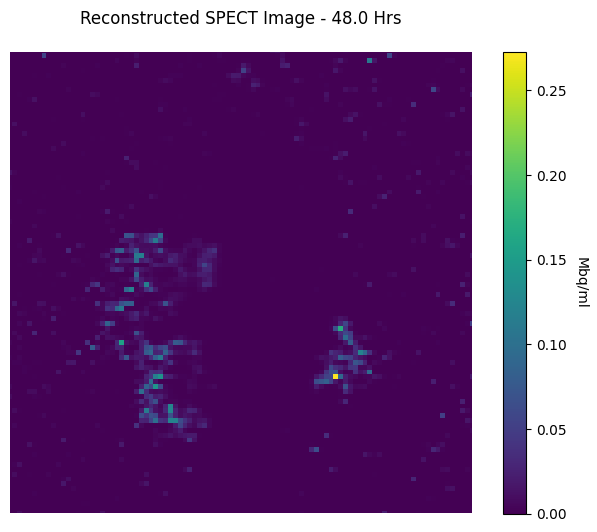

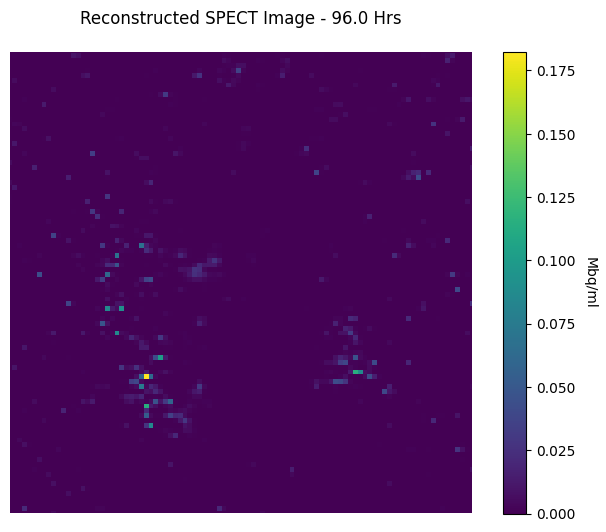

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

def plot_recon_volume(file_path, time_point):
    """Plot a single reconstructed volume with improved formatting"""
    vol = sitk.GetArrayFromImage(sitk.ReadImage(file_path))
    plt.figure(figsize=(8, 6))
    im = plt.imshow(vol[:, 60, :][::-1], cmap='viridis')
    plt.title(f'Reconstructed SPECT Image - {time_point/60} Hrs', pad=20)
    cbar = plt.colorbar(im)
    cbar.set_label('Mbq/ml', rotation=270, labelpad=15)
    plt.axis('off')
    plt.ylim(65,160)
    plt.xlim(15,110)
    plt.gca().invert_yaxis()  
    plt.show()
    return vol

# Base path
base_path = "/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/Output_Folder_Poster_For_real/RECON_Outputs"

# Time points and corresponding files
times = [240, 1440, 2880, 5760]
volumes = {}

# Plot each timepoint
for i, time in enumerate(times):
    file_path = f"{base_path}/RECON_frame{i}.nii"
    volumes[time] = plot_recon_volume(file_path, time)

    

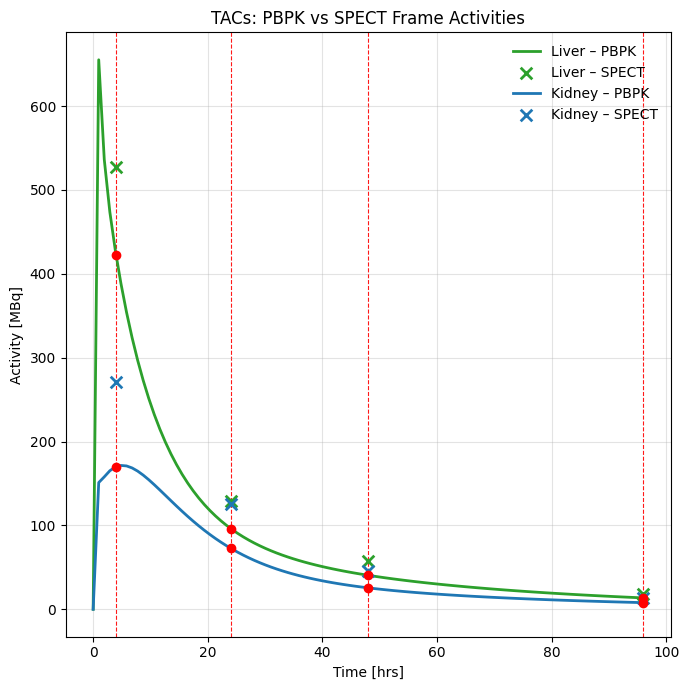

In [134]:
import os
import numpy as np
import matplotlib.pyplot as plt

def load_tac_bins(base_path, pbpk_name, voi):
    t  = np.fromfile(os.path.join(base_path, f"{pbpk_name}_{voi}_TAC_time.bin"),     dtype=np.float32)
    y  = np.fromfile(os.path.join(base_path, f"{pbpk_name}_{voi}_TAC_values.bin"),   dtype=np.float32)
    ts = np.fromfile(os.path.join(base_path, f"{pbpk_name}_{voi}_sample_times.bin"), dtype=np.float32)
    ys = np.fromfile(os.path.join(base_path, f"{pbpk_name}_{voi}_sample_values.bin"), dtype=np.float32)
    return t, y, ts, ys

def find_vois(base_path, pbpk_name):
    vois = []
    for fn in os.listdir(base_path):
        if fn.startswith(f"{pbpk_name}_") and fn.endswith("_TAC_time.bin"):
            vois.append(fn[len(pbpk_name)+1:-len("_TAC_time.bin")])
    return sorted(vois)

def plot_tac_with_spect(base_path, pbpk_name):
    # ---- SPECT frame activities from RECON (MBq) ----
    spect_vals = {
        "Liver":  [526.9458948, 129.4651644, 57.59162708, 18.77900648],
        "Kidney": [270.5795,    125.23655,   45.27835,    13.403694375],
    }
    # frame times (min → hours)
    frame_times_min = np.array([240, 1440, 2880, 5760], dtype=float)
    frame_times_hrs = frame_times_min / 60.0

    colors = {"Liver": "tab:green", "Kidney": "tab:blue"}

    # pick VOI names that exist (Kidney vs Kidneys)
    vois = find_vois(base_path, pbpk_name)
    kidney_name = "Kidney" if "Kidney" in vois else ("Kidneys" if "Kidneys" in vois else None)
    liver_name  = "Liver"  if "Liver"  in vois else None

    fig, ax = plt.subplots(figsize=(7, 7))

    # ---- Liver ----
    if liver_name:
        t, y, _, _ = load_tac_bins(base_path, pbpk_name, liver_name)   # t in minutes
        ax.plot(t/60.0, y, color=colors["Liver"], linewidth=2.0, label="Liver – PBPK", zorder=2)
        # red dots at the PBPK values evaluated exactly at the frame times
        y_pbpk_at_frames = np.interp(frame_times_min, t, y)
        ax.scatter(frame_times_hrs, y_pbpk_at_frames, s=36, color="red", zorder=5, label="_nolegend_")
        # SPECT frame activities (X markers)
        ax.scatter(frame_times_hrs, spect_vals["Liver"], marker='x', s=70, linewidths=2,
                   color=colors["Liver"], label="Liver – SPECT", zorder=4)

    # ---- Kidney(s) ----
    if kidney_name:
        t, y, _, _ = load_tac_bins(base_path, pbpk_name, kidney_name)  # t in minutes
        ax.plot(t/60.0, y, color=colors["Kidney"], linewidth=2.0, label="Kidney – PBPK", zorder=2)
        y_pbpk_at_frames = np.interp(frame_times_min, t, y)
        ax.scatter(frame_times_hrs, y_pbpk_at_frames, s=36, color="red", zorder=5, label="_nolegend_")
        ax.scatter(frame_times_hrs, spect_vals["Kidney"], marker='x', s=70, linewidths=2,
                   color=colors["Kidney"], label="Kidney – SPECT", zorder=4)

    # optional: frame-time guides
    for x in frame_times_hrs:
        ax.axvline(x, color="red", linestyle="--", alpha=0.9, linewidth=0.8, zorder=1)

    ax.set_xlabel("Time [hrs]")
    ax.set_ylabel("Activity [MBq]")
    ax.set_title("TACs: PBPK vs SPECT Frame Activities")
    ax.grid(True, alpha=0.35)
    ax.legend(frameon=False)  # four legend entries only
    fig.tight_layout()
    plt.show()

# --- run ---
if __name__ == "__main__":
    base_path = "/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/Output_Folder_Poster_For_real/PBPK_Outputs"
    pbpk_name = "PBPK"
    plot_tac_with_spect(base_path, pbpk_name)
